# Setting things Up #
In this file I will perform a simulation of IPSII imaging in one dimension.  First I will import some things I will need.  Then I will set up different parameters.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import hilbert

# Size of area being imaged
L = 1

# Width of reference pinhole
wpinhole = 0.01

# Number of points to use for calculations
N = 1000

# Number of k values = number of measurements
# =  number of pixels in final image (this should be even)
Nk = 100

# Number of steps in phase per sine wave cycle when simulating the phase shifting with time
Nphase = 20

# Number of cycles when simulating the phase shifting with time
Ncycle = 5


Next, I'll make an array of x values and use this to generate the 1D function I'm going to image.

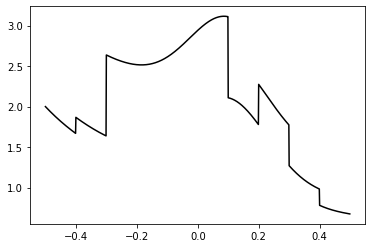

In [2]:
# An array of N points going from -L/2 to L/2
x = np.arange(-L/2,L/2,L/N)

# generate some arbitrary object (function) to image
obj = np.exp(-(x-0.1)**2*30)+1/(1+x)
obj[abs(x+0.1) < 0.2] += 1.0
obj[abs(x-0.25) < 0.05] += 0.5
obj[abs(x) < 0.4] += 0.2

# Plot the object for reference
plt.plot(x,obj,'k')
plt.show()

Next I'm going to set up an array containing all of the spatial frequencies of the different interfernce patterns I'm going to use to gather data about the object.

In [3]:
# spacing between k values
dk = 2*np.pi/L

# minimum and maximum k value
kmin = -(Nk//2)*dk 
kmax = (Nk//2)*dk 

# calculate k values
k = np.arange(kmin,kmax,dk)


# Simulate taking IPSII data #
In the next bit of code I'm going to simulate what happens when we take measurements in an IPSII imaging setup.  In our IPSII apparatus, for each spatial frequency we get a signal which changes in time sinusoidally as we scan the phase of the interference pattern.  In my code I will store each of the time signals in an array called "signal."  There is also another detector in the other interferometer output which has a pinhole in front of it.  This allows us to record a "reference" signal which is the intensity as a function of time that is present in the center of our object.  The reference time signals are held in an array called "reference."

In [4]:
# place to store simulated signal from object
signal = np.empty((Nk,Nphase*Ncycle))

# place to store simulated signal from pinhole
reference = np.empty((Nk,Nphase*Ncycle))

Now we're going to go through each spatial frequency.  For each spatial frequency, we first calculate a random phase to simulate the optical phase of the interferometer drifting.  We then step forward in time, scanning the relative phase of the laser beams with time.  At each time (phase), we calculate the interference pattern for the given spatial frequency at the given phase.  Then we calculate the reference signal at that time by adding together the intensity at each point within the area of the pinhole.  We calculate the signal at this phase for the given spatial frequency by multiplying the pattern with the object and summing up the total transmitted light power over the whole object.  I also add a random number at each point in time to simulate noise.

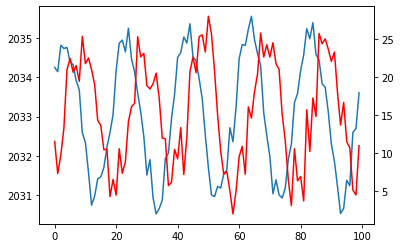

In [5]:
# Go over each different sine wave
for i in range(Nk):
    # For each interference pattern simulate the phase changing in time
    # starting with a random phase
    phio = np.random.random()*2*np.pi;
    for tstep in range(Nphase*Ncycle):
        # phase of pattern for this time step
        phi = phio+2*np.pi*tstep/Nphase
        # generate interference pattern for this wavenumber at this time step 
        pattern = 1+np.cos(k[i]*x+phi)
        # Signal on pinhole at this time
        reference[i,tstep] = np.sum(pattern[abs(x) < wpinhole/2]) + 10*np.random.random() 
        # Signal on image detector at this time
        signal[i,tstep] = np.sum(pattern*obj) + 1*np.random.random()


# Plot one of the signals
ax = plt.gca()
ax.plot(signal[Nk//4,:])
ax2 = ax.twinx()
ax2.plot(reference[Nk//4,:],'r')
plt.show()


# Calculate Fourier coefficients #
Now that we have our simulated data, we will find the amplitude and phase (relative to the reference signal) of each signal at each spatial frequency.  This could be done by fitting the signal and reference data for each spatial frequency to a sine wave to find the amplitude and phase.  But a faster method is to use lock-in detection.  To get the in-phase value at any given spatial frequency, we first remove the DC offset from the signal and the reference.  Then we multiply them together point by point and average the result.  To get the quadrature component, we first use a Hilbert transform on the reference signal to get the "cosine" version of the reference signal, and then multiply the transformed reference with the signal, point by point, and then average the result.  We then calculate the Fourier coefficient for the given spatial frequency from the in-phase and quadrature signal.

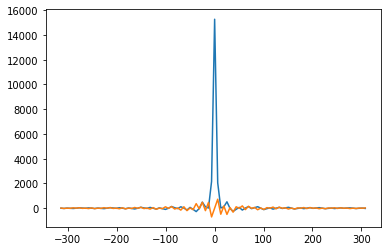

In [6]:
# Place to store the Fourier coefficients
c = np.empty(Nk).astype(np.complex)

# go over each wavenumber
for i in range(Nk):
    # Find sine and cosine coefficients by using lock-in detection with
    # reference signal as the local oscillator.
    
    # We have to treat the "DC" term separately because the standard 
    # proceedure of removing the offset will kill it.
    # Also, it involves an extra factor of 2.
    # Rather than seeing if it is equal to zero, I check to see if
    # k is close to zero.  Otherwise rounding error can keep us from
    # finding the DC term.
    if(abs(k[i]) < dk/40):
        c[i] = np.mean(signal[:,:]*reference[:,:])/2
    else:
        # Get rid of offsets
        ref = reference[i,:] - np.mean(reference[i,:])
        sig = signal[i,:] - np.mean(signal[i,:])
        
        # Use a Hilbert transform to find the phase-shifted reference 
        # that we need to find the sine coefficient
        sref = np.imag(hilbert(ref))
    
        # cosine coefficient
        a = np.mean(ref*sig)
        
        # sine coefficient
        b = np.mean(sref*sig)
        
        # Calculate complex coefficient from sine and cosine coefficients  
        c[i] = a + 1j*b

# Plot the Fourier coefficients    
plt.plot(k,np.real(c))
plt.plot(k,np.imag(c))
plt.show()

# Shift the zero spatial frequency to the edge of the data, because
# that's how the numpy fft code represents it.
c = np.fft.ifftshift(c)        

# Inverse transform #
To calculate our image, we just do the inverse transform.

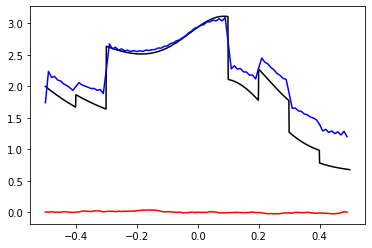

In [7]:
# Get the image by taking the inverse transform.
# We have to "fftshift" the image because the standard fft
# code assumes that x = 0 at the edge of the data, but
# we assumed it is in the middle.
img = np.fft.fftshift(np.fft.ifft(c))

# normalize the image
img *= obj[N//2]/img[Nk//2]

# Plot the image along with the object
plt.plot(x,obj,'k')
ximg = np.arange(-L/2,L/2,1/Nk)
plt.plot(ximg,np.real(img),'b')
plt.plot(ximg,np.imag(img),'r')
plt.show()
